In [3]:
!git clone https://github.com/ry4n-s/autonomy-bootcamp.git

fatal: destination path 'autonomy-bootcamp' already exists and is not an empty directory.


In [4]:
!git config --global user.name "Ryan S"
!git config --global user.email "ryanstefanov04@gmail.com"

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

Import numpy and matplot so we can visualize.

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

train_set = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_set = torchvision.datasets.CIFAR10(root='/data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48050164.04it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


The 0.5 tuples indicate an approximation of the mean and standard deviation values over (r,g,b). The CIFAR-10 dataset is available in torchvision. The train variables are used for training, and the val variables are used for validation. The classes are the different types of images we are going to use. 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_1 = nn.Conv2d(3, 16, 3, 1, padding = 1) #The input is a color image so 3 i/p channels, 16 filters, kernel size is set to 3 to avoid overfitting, stride is 1, padding is 1 to extract all edge features
    self.conv_2 = nn.Conv2d(16, 32, 3, 1, padding = 1) #Double the feature maps for every convolution layer
    self.conv_3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc_1 = nn.Linear(4*4*64, 500) #Image size is 32*32, after three max pooling layers, it reduces to 4*4 and 64 bc our last conv layer has 64 outputs. Output nodes is 500
    self.dropout_1 = nn.Dropout(0.2) #Reduces the chance of overfitting in training
    self.fc_2 = nn.Linear(500, 10) #There are 10 output nodes since we have 10 different kinds of images

  def forward(self, x):
    x = F.relu(self.conv_1(x)) #Apply relu to each output of the conv layer
    x = F.max_pool2d(x, 2, 2,) #Max pooling layer with kernel of 2 and stride of 2
    x = F.relu(self.conv_2(x)) 
    x = F.max_pool2d(x, 2, 2,) 
    x = F.relu(self.conv_3(x)) 
    x = F.max_pool2d(x, 2, 2,)
    x = x.view(-1, 4*4*64) #Flatten our images to 1D to input it to the fully connected layers
    x = F.relu(self.fc_1(x))
    x = self.dropout_1(x) #Applying dropout b/t ;ayers which exhange the highest parameters
    x = self.fc_2(x)
    return x 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net().to(device)

cuda:0


In the first function we initialize. We use a convolutional neural network. Relu converts linear functions to non-linear functions. 

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #Summarizes the everage difference between the predicted values and the actual values
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #High Momentum reaches the local min as fast as possible

In [9]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):   #Training our model
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.to(device) #Input to device
    labels = labels.to(device)
    outputs = net(inputs) #Every batch of 100 images are put as input
    loss = criterion(outputs, labels) #Calculates loss after each batch 

    optimizer.zero_grad() #sets the initial gradient to 0
    loss.backward() #Backpropagates the loss
    optimizer.step() #Updates the weights and bias values for each single step

    _, preds = torch.max(outputs, 1) #Takes the highest value of prediction
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) #Calculates the accuracy by taking the sum of all correct predictions in the batch 

  with torch.no_grad(): #We don't need gradients for validation
    for val_inputs, val_labels in val_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)  
      val_outputs = net(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size) #Loss per epoch
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size) #Accuracy per epoch
  running_loss_history.append(epoch_loss) #Appending for displaying
  running_corrects_history.append(epoch_acc.cpu().numpy())

  val_epoch_loss = val_running_loss/(len(val_loader)*batch_size) 
  val_epoch_acc = val_running_corrects.float()/(len(val_loader)*batch_size) 
  val_running_loss_history.append(val_epoch_loss) 
  val_running_corrects_history.append(val_epoch_acc.cpu().numpy())

  print('epoch:', e+1)
  print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch: 1
training loss: 0.0084, acc 0.2094 
validation loss: 0.0074, validation acc 0.3014
epoch: 2
training loss: 0.0066, acc 0.3830 
validation loss: 0.0061, validation acc 0.4355
epoch: 3
training loss: 0.0057, acc 0.4745 
validation loss: 0.0053, validation acc 0.4909
epoch: 4
training loss: 0.0051, acc 0.5239 
validation loss: 0.0049, validation acc 0.5319
epoch: 5
training loss: 0.0047, acc 0.5672 
validation loss: 0.0047, validation acc 0.5590
epoch: 6
training loss: 0.0043, acc 0.6054 
validation loss: 0.0043, validation acc 0.5926
epoch: 7
training loss: 0.0040, acc 0.6365 
validation loss: 0.0041, validation acc 0.6160
epoch: 8
training loss: 0.0037, acc 0.6633 
validation loss: 0.0039, validation acc 0.6298
epoch: 9
training loss: 0.0035, acc 0.6871 
validation loss: 0.0038, validation acc 0.6359
epoch: 10
training loss: 0.0032, acc 0.7077 
validation loss: 0.0036, validation acc 0.6539
epoch: 11
training loss: 0.0030, acc 0.7277 
validation loss: 0.0036, validation acc 0.66

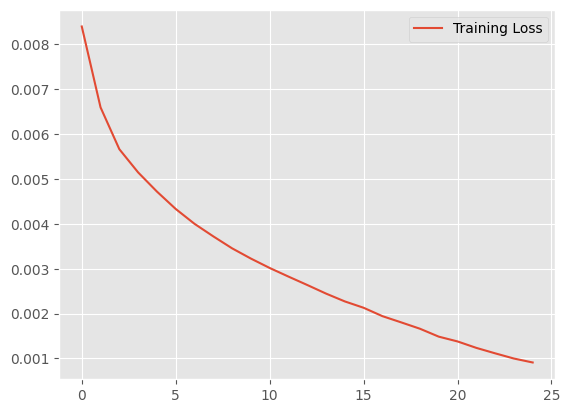

In [10]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='Training Loss')
plt.legend()

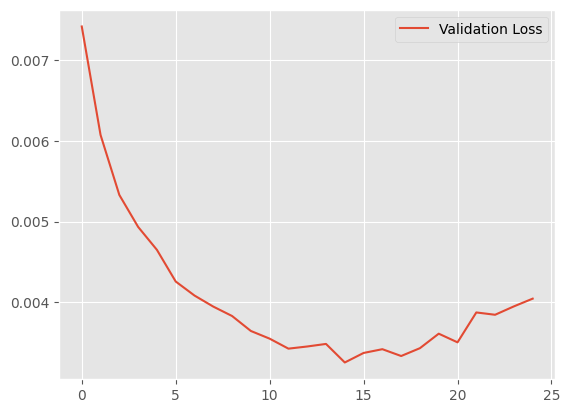

In [11]:
plt.style.use('ggplot')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

In [17]:
%cd autonomy-bootcamp

/content/autonomy-bootcamp


In [18]:
!git add *

In [22]:
!git commit -m "Initial creation of the autonomy bootcamp"

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
